<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow prat 3: Scaling up

We'll be scaling up to all 101 classes of food.

Our goal is to outperform the original Food101 paper (50.76%) with 10% of training data

https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [ ]:
!nvidia-smi

Mon Oct 30 10:10:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created series of helper functions. Now we're going to import them

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-30 13:12:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-30 13:12:16 (24.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
# Import series of helper functions into our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

10% of the training data, let's download it.

In [10]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the data
unzip_data("101_food_classes_10_percent.zip") # without .zip produces error

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-10-30 13:13:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.207, 209.85.234.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   204MB/s    in 7.0s    

2023-10-30 13:13:15 (221 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [11]:
# How many images/classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75

In [12]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes dataset

StepsŁ
1. Setup a model checkpoint callback
2. Create a data augmentation layer to build data augmentation right into the model
3. Build a headless Functional EfficientNetB0 backboned model
4. Compile the model
5. Feature extract for 5 epochs and validate on 15% of the test data


In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation as a layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(.2),
    preprocessing.RandomHeight(.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomZoom(.2),
    # preprocessing.Rescale(1./255.) #when using EfficientNet not needed
], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable output layer
inputs = layers.Input(shape=(224, 224, 3), name="input")
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # in inference mode - stays frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names),
                       activation="softmax",
                       name="output")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get the summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 output (Dense)              (None, 101)               129381    
                                                             

In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit
history_1 = model.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("experiments","10_percent_data"), checkpoint_callback])

Saving TensorBoard log files to: experiments/10_percent_data/20231030-101142
Epoch 1/5
237/237 [==============================] - 127s 470ms/step - loss: 3.3845 - accuracy: 0.2779 - val_loss: 2.5243 - val_accuracy: 0.4399
Epoch 2/5
237/237 [==============================] - 86s 360ms/step - loss: 2.1972 - accuracy: 0.4990 - val_loss: 2.0405 - val_accuracy: 0.5011
Epoch 3/5
237/237 [==============================] - 70s 293ms/step - loss: 1.8268 - accuracy: 0.5653 - val_loss: 1.8847 - val_accuracy: 0.5201
Epoch 4/5
237/237 [==============================] - 64s 266ms/step - loss: 1.5985 - accuracy: 0.6125 - val_loss: 1.7957 - val_accuracy: 0.5320
Epoch 5/5
237/237 [==============================] - 59s 248ms/step - loss: 1.4548 - accuracy: 0.6451 - val_loss: 1.7406 - val_accuracy: 0.5445


In [ ]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 65s 82ms/step - loss: 1.5665 - accuracy: 0.5910


[1.5665022134780884, 0.5910494923591614]

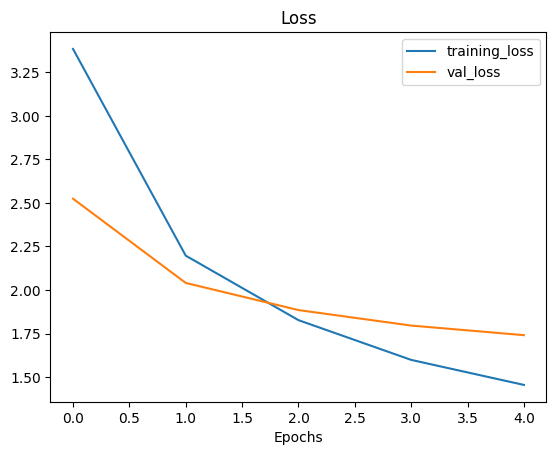

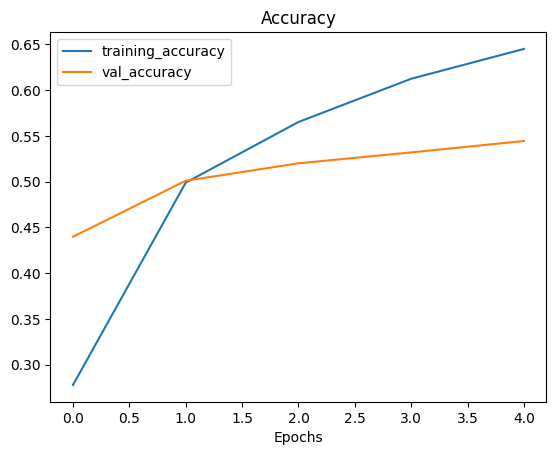

In [ ]:
plot_loss_curves(history_1)

Overfitting HA!

## Fine Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze the bottom layers except the top 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #10x lower lr
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Which layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input True
data_augmentation True
efficientnetb0 True
global_avg_pool True
output True


In [ ]:
# Which layers are trainable in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Fit the model
initial_epochs = 5
total_epochs = initial_epochs + 5
history_2 = model.fit(train_data_10_percent,
                      epochs=total_epochs,
                      initial_epoch=history_1.epoch[-1],
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)))

Epoch 5/10
237/237 [==============================] - 49s 204ms/step - loss: 1.0352 - accuracy: 0.7249 - val_loss: 1.6941 - val_accuracy: 0.5514
Epoch 6/10
237/237 [==============================] - 50s 210ms/step - loss: 0.9590 - accuracy: 0.7464 - val_loss: 1.6904 - val_accuracy: 0.5548
Epoch 7/10
237/237 [==============================] - 52s 217ms/step - loss: 0.8982 - accuracy: 0.7599 - val_loss: 1.6787 - val_accuracy: 0.5538
Epoch 8/10
237/237 [==============================] - 54s 227ms/step - loss: 0.8521 - accuracy: 0.7735 - val_loss: 1.6555 - val_accuracy: 0.5638
Epoch 9/10
237/237 [==============================] - 45s 188ms/step - loss: 0.7997 - accuracy: 0.7851 - val_loss: 1.7009 - val_accuracy: 0.5495
Epoch 10/10
237/237 [==============================] - 46s 193ms/step - loss: 0.7454 - accuracy: 0.8026 - val_loss: 1.7225 - val_accuracy: 0.5495


In [ ]:
# Evaluate on the whole data
results_2 = model.evaluate(test_data)
results_2

790/790 [==============================] - 69s 87ms/step - loss: 1.5030 - accuracy: 0.6060


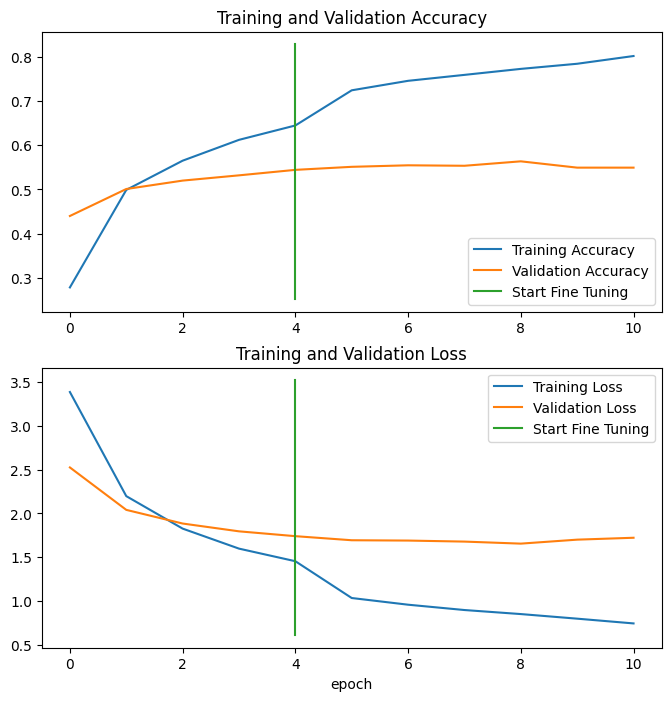

In [ ]:
# Compare the histories
compare_historys(history_1, history_2, initial_epochs=5)

## Saving and loading our model

In [ ]:
# Save the fine-tuned model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model")

In [ ]:
# Load and evaluate the whole model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model")

In [ ]:
# Evaluate the loaded model and compare to the pre saved one
results_2_1 = loaded_model.evaluate(test_data)
results_2_1

790/790 [==============================] - 68s 82ms/step - loss: 1.5030 - accuracy: 0.6060


[1.5030308961868286, 0.6059802174568176]

In [ ]:
results_2

[1.5030308961868286, 0.6059802174568176]

## Evaluating the performance of the big dog model across all different classes

Make predictions and visualize them to find out which are the most wrong

In [3]:
import tensorflow as tf

# Importing Daniel's model to get the same results
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-10-30 13:11:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.207, 172.217.212.207, 108.177.111.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   107MB/s    in 0.4s    

2023-10-30 13:11:57 (107 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [7]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model_mdb = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [13]:
# Evaluate loaded model
results_mdb = model_mdb.evaluate(test_data)
results_mdb

790/790 [==============================] - 77s 85ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [14]:
# Making predictions with model
preds_probs = model_mdb.predict(test_data, verbose=1)

790/790 [==============================] - 64s 79ms/step


In [15]:
# How many predictions are there
len(preds_probs)

25250

In [16]:
# What's the shape of a prediction
preds_probs[0].shape

(101,)

In [17]:
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [18]:
# Prediction probability array with a probability value attached to each class
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

In [19]:
print(f"The class with the highest predicted probability for sample 0 is:\n {test_data.class_names[tf.argmax(preds_probs[0])]}")

The class with the highest predicted probability for sample 0 is:
 gyoza


In [21]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [24]:
# Get the test data labels
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())  #currently the labels are one-hot encoded where there's 1, we need the index to determine which class this is
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
# How many y_labels are there
len(y_labels)

25250

## Evaluating the models predictions



In [28]:
# SciKit Learn accuracy score
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [29]:
import numpy as np
np.isclose(sklearn_accuracy, results_mdb[1])

True

## Let's get visual: confusion matrix

In [32]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100))

## Classification report

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [36]:
# Create a plot of class-respective scores
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
class_names = test_data.class_names

In [37]:
# Create empty dict
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and F1 scores to dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [40]:
# Turn f1 scores into a dataframe
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


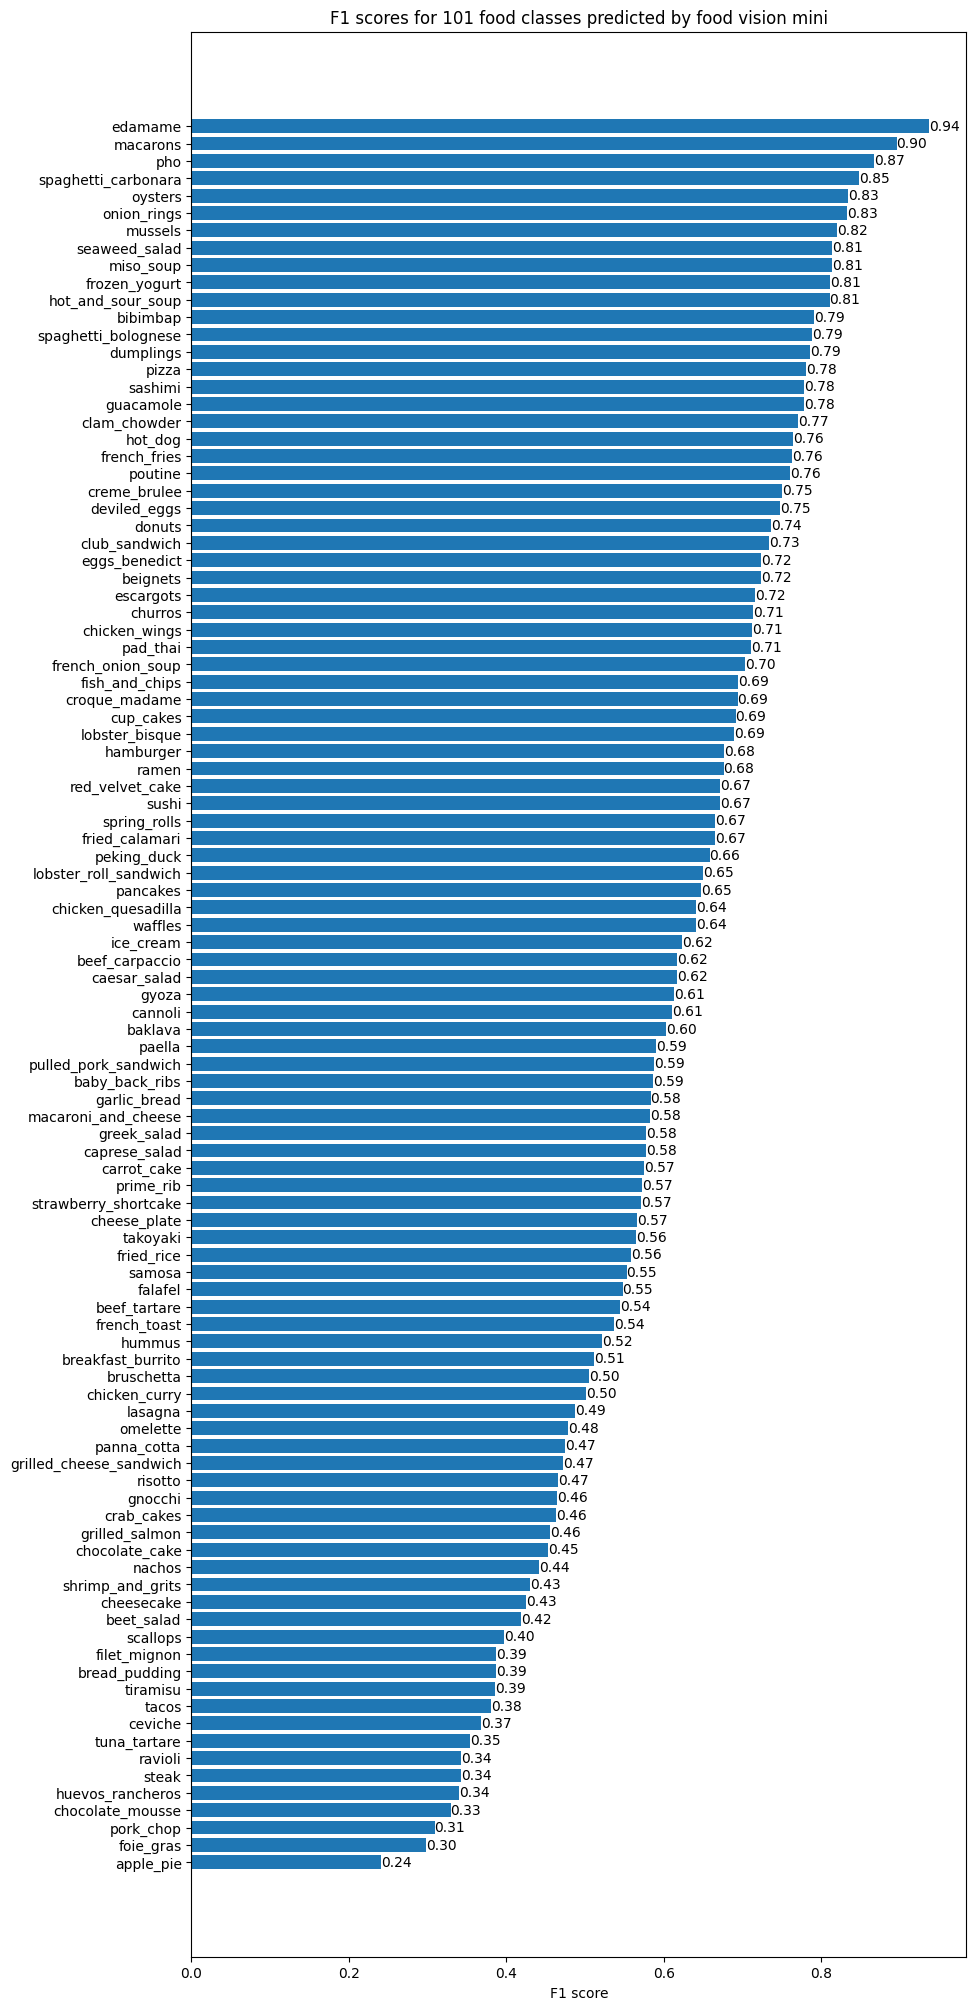

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,25))

scores = ax.barh(np.arange(len(f1_scores)), f1_scores["f1-score"].values) # we have as many slots as there are values and each one gets the respective f1 value
ax.set_yticks(np.arange(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1 score")
ax.set_title("F1 scores for 101 food classes predicted by food vision mini")
ax.invert_yaxis()
ax.bar_label(scores, fmt="%.2f");

## Visualizing predictions on custom images

Let's make a function to
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a tensor using `tf.io.decode_image()`
* Resize the image to be the same size as the images in train and test data using `tf.image.resize()`
* Scale the image to get all the pixel values between o and 1 if necessary


In [61]:
# Create a function to load and prepare images
def load_and_prep_img(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape.

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of the target square image size
    scale (bool): whether or not to rescale the image so that the pixel values are between 0 and 1

  Returns:
   Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into a tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, (img_shape, img_shape))

  # Scale
  if scale:
    # Rescale the image (get all values from between 0 and 255 to between 0 and 1)
    return img/255.
  else:
    return img # for EfficientNet not necessary

1. Load random images from the test dataset
2. Make predictions
3. Plot the images, predictions and correct labels

In [ ]:
# Make predictions on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  # Choose a random file
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load image
  img = load_and_prep_img(filepath, scale=False)
  pred_prob = model_mdb.predict(img)
  pred_class = class_names[pred_prob.argmax()]

